<a href="https://colab.research.google.com/github/ashkwart/Ashley-Website/blob/main/Week2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q census us

In [2]:
%config InlineBackend.figure_formats = ["svg"]

import matplotlib.pyplot as plt
import pandas as pd

from census import Census
from us import states

In [3]:
census = Census("", year=2020)

# Week 2: Exploring the U.S. Census, part 1 (population data)

In this notebook, we'll explore the most famous and essential dataset published by the U.S. Census Bureau: the decennial enumeration of the U.S. population. This enumeration is [required by Article I of the U.S. Constitution](https://www.census.gov/programs-surveys/decennial-census/about/census-constitution.html), and the challenges of processing Census data as the national population grew throughout the 19th century led to the development of [a tabulating machine](https://www.computerhistory.org/revolution/punched-cards/2/2) that was [first used for processing the 1890 U.S. Census](https://www.smithsonianmag.com/smithsonian-institution/herman-holleriths-tabulating-machine-2504989/). This machine read punched cards that encoded Census responses and generated summary statistics (such as the number of foreign-born children under 18 in a particular state, or the number of married women in a particular city). The company that developed this tabulating machine was later renamed to IBM.

The technical demands of analyzing U.S. Census data were therefore a catalyst in the early development of computing; in the 130 years or so since the dawn of this automated tabulation technology, Census data has become exponentially more detailed and accessible. Here, we'll focus on a small slice of the 2010 and 2020 decennial Census data published online via the [Census API](https://www.census.gov/data/developers/data-sets.html).


<img width="600" alt="Herman Hollerith's tabulating machine" src="https://www.ibm.com/content/dam/connectedassets-adobe-cms/worldwide-content/arc/cf/ul/g/a6/a6/hollerithtabulator_sorter.component.simple-narrative-nocrop-xl-retina.ts=1702922330895.jpg/content/adobe-cms/us/en/history/punched-card-tabulator/jcr:content/root/table_of_contents/body/content_section_styled/content-section-body/simple_narrative/image">

_Herman Hollerith's tabulating machine for the 1890 U.S. Census (photo credit: [IBM](https://www.ibm.com/history/punched-card-tabulator))._



## Fetching population data

Here, we'll retrieve population statistics by race from the Census API for all counties in New York. Census data releases are organized into tables; [Table P1](https://data.census.gov/table/DECENNIALPL2020.P1?g=040XX00US36) breaks down population by racial category. For ease of use, we'll map the column names returned by the Census API to their corresponding racial categories: for instance, the `P1_004N` column corresponds to Black population. (Full column definitions are available in the [API documentation](https://api.census.gov/data/2020/dec/pl/variables.html).)

In [4]:
p1_population_columns = {
    "P1_003N": "white",	      # White alone
    "P1_004N": "black",	      # Black or African American alone
    "P1_005N": "amin",        # American Indian and Alaska Native alone
    "P1_006N": "asian",       # Asian alone
    "P1_007N": "nhpi",        # Native Hawaiian and Other Pacific Islander alone
    "P1_008N": "other",       # Some Other Race alone
    "P1_009N": "two_or_more", # Two or more races
}

When fetching data from the Census API, we usually identify geographic regions (states, counties, etc.) by their [FIPS code](https://en.wikipedia.org/wiki/Federal_Information_Processing_Standard_state_code). For instance, the FIPS code for the state of New York is 36. The `us` package exposes identifiers (FIPS codes, postal abbreviations) for the U.S. states.

In [11]:
state = states.GA

In [13]:
print(state, state.abbr, state.fips)

Georgia GA 13


Here, we specify:
* The columns we want to fetch from the Census API (the `NAME` column, and the 7 columns from Table P1 listed in `p1_population_columns` above).
* The regions we want to fetch column values for (all counties in New York).

In [ ]:
county_populations = census.pl.get(
    ("NAME", *p1_population_columns),
    geo={
        "for": "county:13135", #input county fips code here
        "in": f"state:{state.fips}",
    }
)

The Census API returns a list of dictionaries; each contains column values for a county.

In [ ]:
county_populations[0]

{'NAME': 'Allegany County, New York',
 'P1_003N': 42555.0,
 'P1_004N': 829.0,
 'P1_005N': 91.0,
 'P1_006N': 379.0,
 'P1_007N': 9.0,
 'P1_008N': 678.0,
 'P1_009N': 1915.0,
 'state': '36',
 'county': '003'}

We can convert this raw response to a Pandas `DataFrame` without any further manipulation.

In [ ]:
race_df = pd.DataFrame(county_populations)

In [ ]:
race_df.head(5)

,NAME,P1_003N,P1_004N,P1_005N,P1_006N,P1_007N,P1_008N,P1_009N,state,county
0,"Allegany County, New York",42555.0,829.0,91.0,379.0,9.0,678.0,1915.0,36,003
1,"Cattaraugus County, New York",68128.0,1043.0,2706.0,567.0,14.0,571.0,4013.0,36,009
2,"Chemung County, New York",70463.0,5315.0,240.0,1432.0,15.0,947.0,5736.0,36,015
3,"Columbia County, New York",51533.0,2557.0,188.0,1431.0,21.0,1584.0,4256.0,36,021
4,"Dutchess County, New York",207251.0,32289.0,1312.0,10781.0,74.0,18380.0,25824.0,36,027


## Postprocessing

We can make `race_df` more usable by applying our mapping from raw column names to human-readable racial categories. We don't need the state and county FIPS codes returned by the Census API by default in the `state` and `county` columns, so we'll drop those columns.

In [ ]:
race_df = race_df.rename(
    columns={"NAME": "name", **p1_population_columns}
).drop(
    columns=["state", "county"]
).set_index("name")

In [ ]:
race_df.head(10)

,white,black,amin,asian,nhpi,other,two_or_more
name,,,,,,,
"Allegany County, New York",42555.0,829.0,91.0,379.0,9.0,678.0,1915.0
"Cattaraugus County, New York",68128.0,1043.0,2706.0,567.0,14.0,571.0,4013.0
"Chemung County, New York",70463.0,5315.0,240.0,1432.0,15.0,947.0,5736.0
"Columbia County, New York",51533.0,2557.0,188.0,1431.0,21.0,1584.0,4256.0
"Dutchess County, New York",207251.0,32289.0,1312.0,10781.0,74.0,18380.0,25824.0
"Essex County, New York",34102.0,676.0,78.0,229.0,12.0,306.0,1978.0
"Genesee County, New York",51541.0,1441.0,419.0,416.0,17.0,1421.0,3133.0
"Herkimer County, New York",55246.0,759.0,108.0,370.0,35.0,382.0,3239.0
"Lewis County, New York",25121.0,109.0,57.0,76.0,11.0,184.0,1024.0


We can sum the values in each column to compute population totals by racial category for the state.

In [ ]:
race_df.sum(axis=0)

,0
white,11143349.0
black,2986172.0
amin,149690.0
asian,1933127.0
nhpi,10815.0
other,2210633.0
two_or_more,1767463.0


Similarly, we can sum the values in each row to compute population totals (across all racial categories) for each county.

In [ ]:
race_df.sum(axis=1)

,0
name,
"Allegany County, New York",46456.0
"Cattaraugus County, New York",77042.0
"Chemung County, New York",84148.0
"Columbia County, New York",61570.0
"Dutchess County, New York",295911.0
...,...
"Washington County, New York",61302.0
"Wayne County, New York",91283.0
"Westchester County, New York",1004457.0


### Visualizing demographics with a pie chart

We can visualize the demographic breakdown of a particular county with [Pandas' pie chart function](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.pie.html).

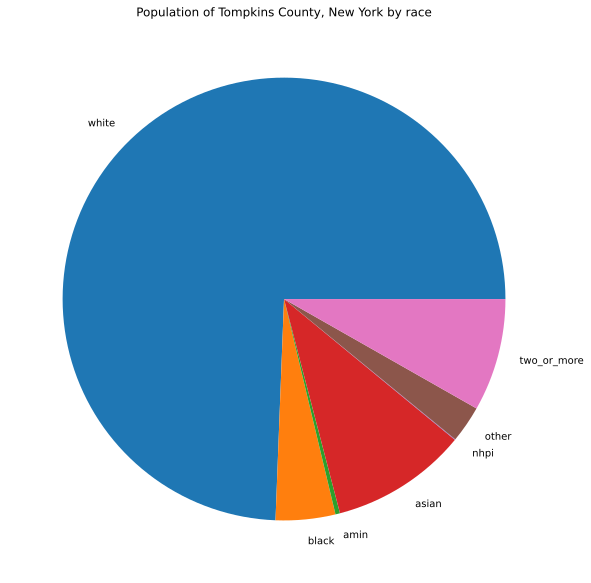

In [ ]:
county = "Tompkins County, New York" #can change county here aswell
ax = race_df.T.plot.pie(y=county, figsize=(10, 10), legend=False)
ax.set_title(f"Population of {county} by race")
ax.set_ylabel("")
plt.show()

We can visualize the demographic breakdown of the whole state in a similar fashion: first, we compute total population by race for the entire state (as illustrated in the section above), and then we plot the resulting Pandas `Series`. This pie chart improves on the county-level pie chart above by showing percentages for each racial category (rounded to the nearest 0.1%).

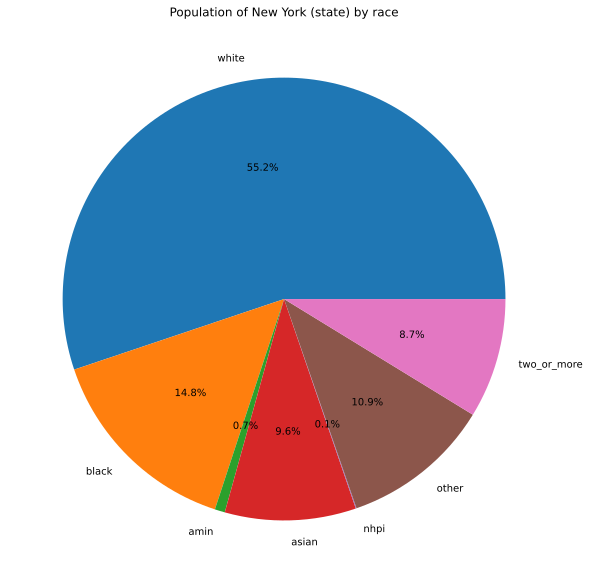

In [ ]:
ax = race_df.sum(axis=0).plot.pie(figsize=(10, 10), autopct="%1.1f%%")
ax.set_ylabel("")
ax.set_title(f"Population of {state} (state) by race")
plt.show()

### Computing percentages

In order to answer questions like "which county in New York has the largest _share_ of Black population?", it's necessary to convert absolute population counts to percentages. To do this, it's convenient to compute a `total` column, then create percentage columns by dividing each race column by the `total` column, then scaling by 100 to convert from fractional values to percentages. Pandas' vector arithmetic functionality makes these operations relatively simple to write: rather than explicitly iterating through each row, we can simply write the multiplication and division operations in terms of columns. The operations will be applied to each row!

In [ ]:
race_df["total"] = race_df.sum(axis=1)

In [ ]:
race_df.head(5)

,white,black,amin,asian,nhpi,other,two_or_more,total
name,,,,,,,,
"Allegany County, New York",42555.0,829.0,91.0,379.0,9.0,678.0,1915.0,46456.0
"Cattaraugus County, New York",68128.0,1043.0,2706.0,567.0,14.0,571.0,4013.0,77042.0
"Chemung County, New York",70463.0,5315.0,240.0,1432.0,15.0,947.0,5736.0,84148.0
"Columbia County, New York",51533.0,2557.0,188.0,1431.0,21.0,1584.0,4256.0,61570.0
"Dutchess County, New York",207251.0,32289.0,1312.0,10781.0,74.0,18380.0,25824.0,295911.0


In [ ]:
categories = list(p1_population_columns.values())
categories

['white', 'black', 'amin', 'asian', 'nhpi', 'other', 'two_or_more']

In [ ]:
for col in categories:
    race_df[f"{col}_pct"] = 100 * race_df[col] / race_df["total"]

In [ ]:
race_df

,white,black,amin,asian,nhpi,other,two_or_more,total,white_pct,black_pct,amin_pct,asian_pct,nhpi_pct,other_pct,two_or_more_pct
name,,,,,,,,,,,,,,,
"Allegany County, New York",42555.0,829.0,91.0,379.0,9.0,678.0,1915.0,46456.0,91.602807,1.784484,0.195884,0.815826,0.019373,1.459445,4.122180
"Cattaraugus County, New York",68128.0,1043.0,2706.0,567.0,14.0,571.0,4013.0,77042.0,88.429688,1.353807,3.512370,0.735962,0.018172,0.741154,5.208847
"Chemung County, New York",70463.0,5315.0,240.0,1432.0,15.0,947.0,5736.0,84148.0,83.736987,6.316252,0.285212,1.701764,0.017826,1.125398,6.816561
"Columbia County, New York",51533.0,2557.0,188.0,1431.0,21.0,1584.0,4256.0,61570.0,83.698230,4.152997,0.305344,2.324184,0.034108,2.572682,6.912457
"Dutchess County, New York",207251.0,32289.0,1312.0,10781.0,74.0,18380.0,25824.0,295911.0,70.038289,10.911727,0.443377,3.643325,0.025008,6.211327,8.726948
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Washington County, New York",55162.0,1715.0,174.0,326.0,23.0,703.0,3199.0,61302.0,89.984014,2.797625,0.283841,0.531793,0.037519,1.146782,5.218427
"Wayne County, New York",80476.0,2562.0,263.0,487.0,15.0,1667.0,5813.0,91283.0,88.160994,2.806656,0.288115,0.533506,0.016432,1.826189,6.368108
"Westchester County, New York",533150.0,141094.0,7466.0,65707.0,339.0,146911.0,109790.0,1004457.0,53.078429,14.046793,0.743287,6.541544,0.033750,14.625912,10.930284


Armed with these percentages, we can now answer demographic questions cast in terms of population shares. For instance, sorting `race_df` by `white_pct` shows that Bronx County contains the smallest share of white population in the state, while Lewis County contains the greatest share.

In [ ]:
race_df.sort_values(by=["white_pct"])

,white,black,amin,asian,nhpi,other,two_or_more,total,white_pct,black_pct,amin_pct,asian_pct,nhpi_pct,other_pct,two_or_more_pct
name,,,,,,,,,,,,,,,
"Bronx County, New York",207573.0,487118.0,21539.0,69559.0,1640.0,493052.0,192173.0,1472654.0,14.095164,33.077559,1.462597,4.723377,0.111364,33.480505,13.049433
"Queens County, New York",621475.0,403077.0,30513.0,660631.0,1718.0,444686.0,243364.0,2405464.0,25.835972,16.756726,1.268487,27.463766,0.071421,18.486496,10.117133
"Kings County, New York",1028774.0,772050.0,20598.0,373680.0,1487.0,302186.0,237299.0,2736074.0,37.600372,28.217439,0.752831,13.657525,0.054348,11.044511,8.672974
"New York County, New York",847604.0,229361.0,9969.0,221995.0,1795.0,208086.0,175441.0,1694251.0,50.028243,13.537605,0.588402,13.102840,0.105947,12.281887,10.355077
"Westchester County, New York",533150.0,141094.0,7466.0,65707.0,339.0,146911.0,109790.0,1004457.0,53.078429,14.046793,0.743287,6.541544,0.033750,14.625912,10.930284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Chenango County, New York",43531.0,357.0,126.0,245.0,15.0,353.0,2593.0,47220.0,92.187632,0.756036,0.266836,0.518848,0.031766,0.747565,5.491317
"Schuyler County, New York",16750.0,101.0,50.0,108.0,1.0,93.0,795.0,17898.0,93.585876,0.564309,0.279361,0.603419,0.005587,0.519611,4.441837
"Hamilton County, New York",4785.0,31.0,14.0,12.0,1.0,22.0,242.0,5107.0,93.694929,0.607010,0.274134,0.234972,0.019581,0.430781,4.738594


This histogram indicates that most counties in New York have a relatively small Black population share (most of the mass is below the 10% mark), but there are a few outlying counties with a large concentration of Black population.

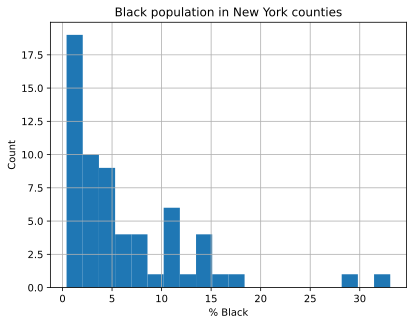

In [ ]:
ax = race_df["black_pct"].hist(bins=20)
ax.set_xlabel("% Black")
ax.set_ylabel("Count")
ax.set_title("Black population in New York counties")
plt.show()

## Adding a dimension: Hispanic or Latino origin

The U.S. Census Bureau does not consider "Hispanic or Latino" a racial category; [rather, it is an ethnic category](https://www.census.gov/acs/www/about/why-we-ask-each-question/ethnicity/) ([this may change with the 2030 Census](https://www.npr.org/2023/01/26/1151608403/mena-race-categories-us-census-middle-eastern-latino-hispanic)). Hispanic or Latino origin and racial identification were therefore considered in separate questions on the 2020 Census questionnaire (if you're curious about the precise wording of the questions, see [this PDF of the questionnaire](https://www2.census.gov/programs-surveys/decennial/2020/technical-documentation/questionnaires-and-instructions/questionnaires/2020-informational-questionnaire-english_DI-Q1.pdf)).

[Table P2](https://data.census.gov/table/DECENNIALPL2020.P2?g=040XX00US36) contains population totals broken down by both race _and_ Hispanic/Latino origin. Let's retrieve county-level statistics from this table. (As with Table P1, column definitions are available in the [API documentation](https://api.census.gov/data/2020/dec/pl/variables.html).) When we rename columns derived from Table P2, **we'll use the prefix `nh_` for columns containing non-Hispanic population and the prefix `h_` for columns containing Hispanic population.**

In [ ]:
p2_non_hispanic_population_columns = {
    "P2_005N": "nh_white",        # White alone
    "P2_006N": "nh_black",        # Black or African American alone
    "P2_007N": "nh_amin",         # American Indian and Alaska Native alone
    "P2_008N": "nh_asian",        # Asian alone
    "P2_009N": "nh_nhpi",         # Native Hawaiian and Other Pacific Islander alone
    "P2_010N": "nh_other",        # Some Other Race alone
    "P2_011N": "nh_two_or_more",  # Two or more races
}

In [ ]:
county_non_hispanic_populations = census.pl.get(
    ("NAME", *p2_non_hispanic_population_columns),
    geo={
        "for": "county:*",
        "in": f"state:{state.fips}",
    }
)

In [ ]:
race_ethnicity_df = pd.DataFrame(county_non_hispanic_populations)

In [ ]:
race_ethnicity_df.head(5)

,NAME,P2_005N,P2_006N,P2_007N,P2_008N,P2_009N,P2_010N,P2_011N,state,county
0,"Allegany County, New York",42327.0,809.0,91.0,373.0,6.0,218.0,1667.0,36,003
1,"Cattaraugus County, New York",67554.0,996.0,2661.0,560.0,9.0,212.0,3435.0,36,009
2,"Chemung County, New York",69559.0,5009.0,198.0,1426.0,15.0,228.0,4775.0,36,015
3,"Columbia County, New York",50795.0,2421.0,70.0,1423.0,16.0,348.0,2955.0,36,021
4,"Dutchess County, New York",198495.0,30126.0,387.0,10635.0,67.0,1956.0,12021.0,36,027


We can apply the same postprocessing steps we applied to Table P1 to clean up the column names.

In [ ]:
race_ethnicity_df = race_ethnicity_df.rename(
    columns={"NAME": "name", **p2_non_hispanic_population_columns}
).drop(
    columns=["state", "county"]
).set_index("name")

In [ ]:
race_ethnicity_df

,nh_white,nh_black,nh_amin,nh_asian,nh_nhpi,nh_other,nh_two_or_more
name,,,,,,,
"Allegany County, New York",42327.0,809.0,91.0,373.0,6.0,218.0,1667.0
"Cattaraugus County, New York",67554.0,996.0,2661.0,560.0,9.0,212.0,3435.0
"Chemung County, New York",69559.0,5009.0,198.0,1426.0,15.0,228.0,4775.0
"Columbia County, New York",50795.0,2421.0,70.0,1423.0,16.0,348.0,2955.0
"Dutchess County, New York",198495.0,30126.0,387.0,10635.0,67.0,1956.0,12021.0
...,...,...,...,...,...,...,...
"Washington County, New York",54605.0,1563.0,149.0,319.0,22.0,143.0,2740.0
"Wayne County, New York",79230.0,2397.0,171.0,473.0,13.0,272.0,4213.0
"Westchester County, New York",497684.0,131010.0,1017.0,64907.0,150.0,8651.0,31704.0


Table P2 only includes _non_-Hispanic population by race, but we can easily derive Hispanic population by race by incorporating totals from Table P1.

In [ ]:
for category in categories:
    race_ethnicity_df[f"h_{category}"] = race_df[category] - race_ethnicity_df[f"nh_{category}"]

In [ ]:
race_ethnicity_df.head(5)

,nh_white,nh_black,nh_amin,nh_asian,nh_nhpi,nh_other,nh_two_or_more,h_white,h_black,h_amin,h_asian,h_nhpi,h_other,h_two_or_more
name,,,,,,,,,,,,,,
"Allegany County, New York",42327.0,809.0,91.0,373.0,6.0,218.0,1667.0,228.0,20.0,0.0,6.0,3.0,460.0,248.0
"Cattaraugus County, New York",67554.0,996.0,2661.0,560.0,9.0,212.0,3435.0,574.0,47.0,45.0,7.0,5.0,359.0,578.0
"Chemung County, New York",69559.0,5009.0,198.0,1426.0,15.0,228.0,4775.0,904.0,306.0,42.0,6.0,0.0,719.0,961.0
"Columbia County, New York",50795.0,2421.0,70.0,1423.0,16.0,348.0,2955.0,738.0,136.0,118.0,8.0,5.0,1236.0,1301.0
"Dutchess County, New York",198495.0,30126.0,387.0,10635.0,67.0,1956.0,12021.0,8756.0,2163.0,925.0,146.0,7.0,16424.0,13803.0


In [ ]:
race_ethnicity_df["total"] = race_ethnicity_df.sum(axis=1)

In [ ]:
non_hispanic_categories = list(p2_non_hispanic_population_columns.values())
non_hispanic_categories

['nh_white',
 'nh_black',
 'nh_amin',
 'nh_asian',
 'nh_nhpi',
 'nh_other',
 'nh_two_or_more']

For convenience, let's construct subtotals for the Hispanic and non-Hispanic populations.

In [ ]:
race_ethnicity_df["nh_total"] = race_ethnicity_df[non_hispanic_categories].sum(axis=1)

In [ ]:
hispanic_categories = [cat.replace("nh_", "h_") for cat in non_hispanic_categories]
hispanic_categories

['h_white',
 'h_black',
 'h_amin',
 'h_asian',
 'h_nhpi',
 'h_other',
 'h_two_or_more']

In [ ]:
race_ethnicity_df["h_total"] = race_ethnicity_df[hispanic_categories].sum(axis=1)

In [ ]:
race_ethnicity_df.head(5)

,nh_white,nh_black,nh_amin,nh_asian,nh_nhpi,nh_other,nh_two_or_more,h_white,h_black,h_amin,h_asian,h_nhpi,h_other,h_two_or_more,total,nh_total,h_total
name,,,,,,,,,,,,,,,,,
"Allegany County, New York",42327.0,809.0,91.0,373.0,6.0,218.0,1667.0,228.0,20.0,0.0,6.0,3.0,460.0,248.0,46456.0,45491.0,965.0
"Cattaraugus County, New York",67554.0,996.0,2661.0,560.0,9.0,212.0,3435.0,574.0,47.0,45.0,7.0,5.0,359.0,578.0,77042.0,75427.0,1615.0
"Chemung County, New York",69559.0,5009.0,198.0,1426.0,15.0,228.0,4775.0,904.0,306.0,42.0,6.0,0.0,719.0,961.0,84148.0,81210.0,2938.0
"Columbia County, New York",50795.0,2421.0,70.0,1423.0,16.0,348.0,2955.0,738.0,136.0,118.0,8.0,5.0,1236.0,1301.0,61570.0,58028.0,3542.0
"Dutchess County, New York",198495.0,30126.0,387.0,10635.0,67.0,1956.0,12021.0,8756.0,2163.0,925.0,146.0,7.0,16424.0,13803.0,295911.0,253687.0,42224.0


It's always important to double-check our calculations. Here, we verify that the Hispanic and non-Hispanic totals add up to the overall population total in each county.

In [ ]:
assert (race_ethnicity_df["h_total"] + race_ethnicity_df["nh_total"] == race_ethnicity_df["total"]).all() #makes sure all math is correct

Now that we've broken down the state population along two dimensions (race and Hispanic/Latino origin), we can answer some more sophisticated demographic questions: for instance, how does the distribution of racial identification differ between the Hispanic and non-Hispanic populations?

In [15]:
ax = race_ethnicity_df[["nh_total", "h_total"]].rename(
    columns={"nh_total": "non-Hispanic", "h_total": "Hispanic"}
).sum(axis=0).plot.pie(figsize=(6, 6), autopct="%1.1f%%")
ax.set_ylabel("")
ax.set_title(f"Population of {state} (state) by Hispanic/Latino origin")

plt.savefig("users/ashleykwarteng/Desktop/nh_population.png", bbox_inches='tight')
plt.show()

NameError: name 'race_ethnicity_df' is not defined

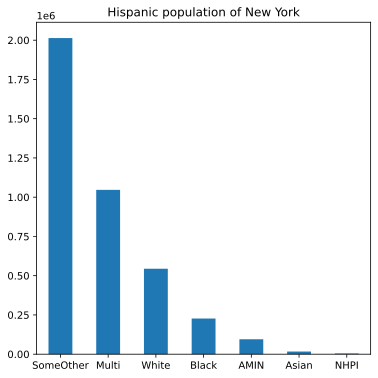

In [ ]:
ax = race_ethnicity_df[hispanic_categories].rename(columns={
    "h_other": "SomeOther",
    "h_asian": "Asian",
    "h_black": "Black",
    "h_white": "White",
    "h_two_or_more": "Multi",
    "h_amin": "AMIN",
    "h_nhpi": "NHPI",
}).sum(axis=0).sort_values(ascending=False).plot.bar(figsize=(6, 6), rot=0)
ax.set_title(f"Hispanic population of {state}")
plt.show()

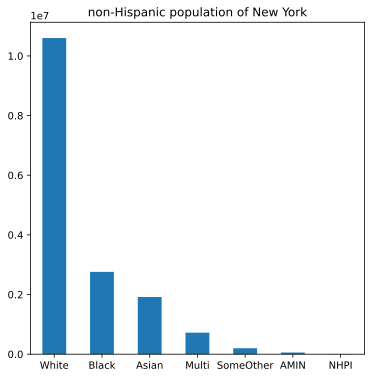

In [ ]:
ax = race_ethnicity_df[non_hispanic_categories].rename(columns={
    "nh_other": "SomeOther",
    "nh_asian": "Asian",
    "nh_black": "Black",
    "nh_white": "White",
    "nh_two_or_more": "Multi",
    "nh_amin": "AMIN",
    "nh_nhpi": "NHPI",
}).sum(axis=0).sort_values(ascending=False).plot.bar(figsize=(6, 6), rot=0)
ax.set_title(f"non-Hispanic population of {state}")
plt.show()

## Homework 2, due Tuesday Feb 11, 1:25pm


For the **data product** part of your homework, explore the census race/ethnicity data.  Pose ONE question and show us a plot that answers it.  Here are some examples to get you thinking...
- How does the share of "white" people change in Texas if I only sort by race (ignoring ethnicity), or if I consider both race and ethnicity and treat Hispanic as a race?  (This could be a pair of pie charts side-by-side, for instance.)
- Which state had its number of multi-racial respondents jump most in absolute numbers between the 2010 and 2020 Census?
- What's the share of Hispanic respondents choosing "Some Other Race" in California? Is it very different from Florida?
- What's the Whitest state with at least 3 million people?
- Which state has the highest share of people who said they belong to ALL SIX races?  (note: to do this, you'd need to fetch new columns from the API)

Be creative!

For the **reading response** part of your homework, refer to the chapter by Nobles.  Pick out and quote one juicy sentence that you underlined when you read the chapter.  React to it and connect it to something from either Scott or Hacking (two other authors we've been discussing).